<a href="https://colab.research.google.com/github/Maithraanand/Applied-DL/blob/main/Vanilla_AutoencoderADL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_helmet_detection_path = kagglehub.dataset_download('andrewmvd/helmet-detection')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/helmet-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/helmet-detection/annotations/BikesHelmets338.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets680.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets62.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets172.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets622.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets477.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets488.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets696.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets71.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets269.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets206.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets705.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets515.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets113.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets546.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets63

Found 764 images belonging to 2 classes.
Loaded image data shape: (764, 64, 64, 3)
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 644ms/step - loss: 0.0665 - val_loss: 0.0424
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 640ms/step - loss: 0.0396 - val_loss: 0.0309
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 632ms/step - loss: 0.0299 - val_loss: 0.0251
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 634ms/step - loss: 0.0249 - val_loss: 0.0230
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 637ms/step - loss: 0.0230 - val_loss: 0.0213
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


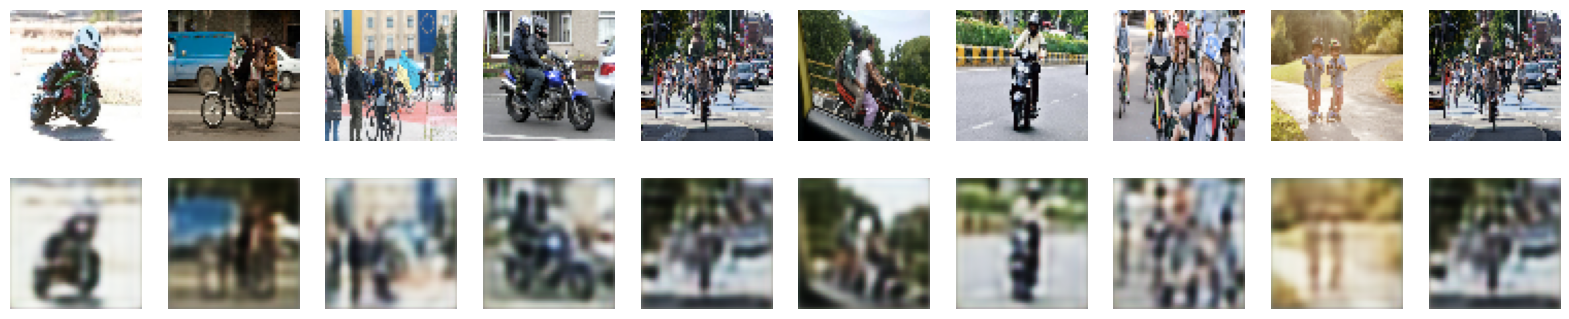

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

# Dataset directory (update if needed)
data_dir = "/kaggle/input/helmet-detection"

# Set image size
img_height, img_width = 64, 64

# Load helmet images using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

image_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Collect all images into a numpy array
x_data = np.concatenate([image_generator[i] for i in range(len(image_generator))], axis=0)
print("Loaded image data shape:", x_data.shape)

# Split data into training and testing sets
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=42)

# Define CNN-based autoencoder
input_img = tf.keras.Input(shape=(img_height, img_width, 3))

# Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
encoded = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)

# Decoder
x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder Model
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")  # Using 'mse' for clearer reconstructions

# Train the autoencoder
autoencoder.fit(
    x_train, x_train,
    epochs=5,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# Predict reconstructed images
decoded_imgs = autoencoder.predict(x_test)

# Display original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")

plt.show()
